In [1]:
from pystac_client import Client  
from shapely.geometry import box
from dotenv import dotenv_values
import datetime
from pystac.item_collection import ItemCollection
from shapely.geometry import shape, Polygon
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt

In [2]:
config = dotenv_values()

ED_USERNAME = config['ED_USERNAME']
ED_PASSWORD = config['ED_PASSWORD']

# Parameteres

In [3]:
aoi_bounds = [-84.28, 43.32, -84, 43.52]
aoi_geo = box(*aoi_bounds)
start_date = datetime.datetime(2022, 1, 1)
stop_date = datetime.datetime.now()
max_items = 1_000

In [50]:
df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

# Search

In [10]:
%%time

STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
api = Client.open(f'{STAC_URL}/LPCLOUD/')
hls_collections = ['HLSL30.v2.0', 'HLSS30.v2.0']

search_params = {"collections": hls_collections,
                 "bbox": aoi_geo.bounds,
                 "datetime": [start_date, stop_date],
                 "max_items": max_items}
resp = api.search(**search_params)
resp_items = resp.item_collection()
resp_items[0]

CPU times: user 432 ms, sys: 104 ms, total: 536 ms
Wall time: 43.1 s


<Item id=HLS.L30.T16TGP.2022002T162211.v2.0>

In [12]:
def get_urls(resp_item: ItemCollection) -> list:
    urls = [asset.href for asset in resp_item.assets.values() if asset.href[-4:] not in ['.xml', '.jpg']]
    return sorted(urls)
def get_tile_id(resp_item: ItemCollection) -> str:
    tile_id = resp_item.id.split('.')[2]
    return tile_id
def get_geometry(resp_item: ItemCollection) -> Polygon:
    geo = shape(resp_item.geometry)
    return geo
    
K = 0
get_urls(resp_items[K])[:2], get_tile_id(resp_items[K]), get_geometry(resp_items[K])

(['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TGP.2022002T162211.v2.0/HLS.L30.T16TGP.2022002T162211.v2.0.B01.tif',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TGP.2022002T162211.v2.0/HLS.L30.T16TGP.2022002T162211.v2.0.B02.tif'],
 'T16TGP',
 <POLYGON ((-83.558 43.213, -83.198 44.19, -84.496 44.226, -84.537 43.238, -8...>)

In [37]:
def create_record(item: ItemCollection):
    return {
        'geometry': get_geometry(item),
        # 'urls': get_urls(item),
        'tile_id': get_tile_id(item),
        'hls_id': item.id
    }
data = list(map(create_record, resp_items))
df_hls = gpd.GeoDataFrame(data, crs=CRS.from_epsg(4326))

In [38]:
df_hls.head()

,geometry,tile_id,hls_id
0,"POLYGON ((-83.55777 43.21297, -83.19804 44.190...",T16TGP,HLS.L30.T16TGP.2022002T162211.v2.0
1,"POLYGON ((-83.87695 42.32152, -83.52623 43.300...",T16TGN,HLS.L30.T16TGN.2022002T162235.v2.0
2,"POLYGON ((-83.18737 43.20121, -83.12426 44.187...",T16TGP,HLS.L30.T16TGP.2022003T161602.v2.0
3,"POLYGON ((-83.24214 42.30245, -83.18188 43.289...",T16TGN,HLS.L30.T16TGN.2022003T161626.v2.0
4,"POLYGON ((-83.18737 43.20121, -83.12426 44.187...",T16TGP,HLS.S30.T16TGP.2022004T162649.v2.0


<Axes: >

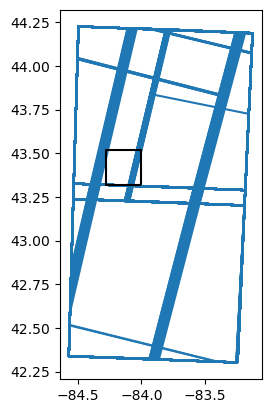

In [39]:
fig, ax = plt.subplots()
df_hls.exterior.plot(ax=ax)
df_aoi.exterior.plot(ax=ax, color='black')

In [40]:
tile_ids = df_hls.tile_id.unique()

<Axes: >

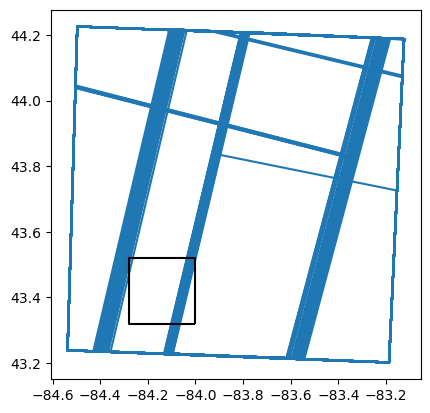

In [41]:
fig, ax = plt.subplots()
df_hls_tile = df_hls[df_hls.tile_id == tile_ids[0]].reset_index(drop=True)
df_hls_tile.exterior.plot(ax=ax)
df_aoi.exterior.plot(ax=ax, color='black')

<Axes: >

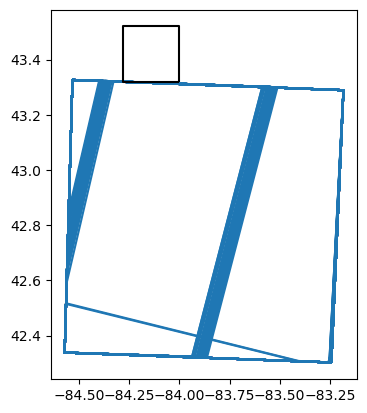

In [42]:
fig, ax = plt.subplots()
df_hls_tile = df_hls[df_hls.tile_id == tile_ids[1]].reset_index(drop=True)
df_hls_tile.exterior.plot(ax=ax)
df_aoi.exterior.plot(ax=ax, color='black')

In [43]:
df_hls_tile = df_hls[df_hls.tile_id == tile_ids[0]].reset_index(drop=True)
percent_coverage = (df_hls_tile.geometry.intersection(aoi_geo).area / aoi_geo.area)
df_hls_tile_min_coverage = df_hls_tile[percent_coverage > .5]

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_15212/2058152580.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  percent_coverage = (df_hls_tile.geometry.intersection(aoi_geo).area / aoi_geo.area)


<Axes: >

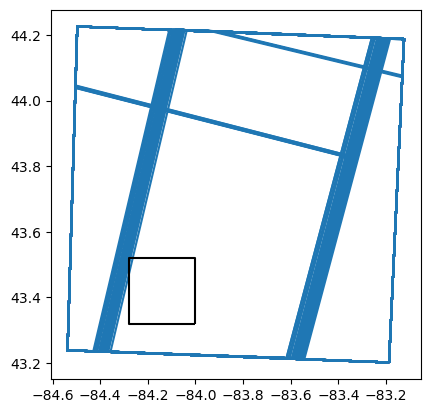

In [44]:
fig, ax = plt.subplots()
df_hls_tile_min_coverage.exterior.plot(ax=ax)
df_aoi.exterior.plot(ax=ax, color='black')

In [45]:
df_hls_tile_min_coverage.shape, df_hls_tile.shape

((213, 3), (307, 3))

In [46]:
df_hls_tile_min_coverage.to_file('aoi.geojson', driver='GeoJSON')